# Transactions Fraud Detection

# Q1: Load Data

In [2]:
from platform import python_version

print(python_version())

3.7.6


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import matthews_corrcoef

In [4]:
# Show all dataframe columns
pd.options.display.max_columns = None

*Note:* Please modify the location of the data file to ready the data table.

In [4]:
df = pd.read_json('/transactions/transactions.txt', lines=True)

In [5]:
#replace white space with nan
df = df.replace(r'^\s*$', np.nan, regex=True)

In [164]:
#changing string types to datetime format
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], format='%Y-%m-%d')
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'], format='%Y-%m-%d')
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'], format='%Y-%m-%d')
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], format='%m/%Y')
print(type(df['transactionDateTime'][0]))
print(type(df['dateOfLastAddressChange'][0]))
print(type(df['accountOpenDate'][0]))
print(type(df['currentExpDate'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [7]:
df.to_csv('/transactions_cleaned.csv')

In [8]:
df.head(10)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
5,830329091,830329091,5000,5000.00,2016-04-19 16:24:27,30.76,In-N-Out #422833,US,US,02,01,fastfood,01/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
6,830329091,830329091,5000,5000.00,2016-05-21 14:50:35,57.28,Krispy Kreme #685312,US,US,02,01,fastfood,05/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
7,830329091,830329091,5000,5000.00,2016-06-03 00:31:21,9.37,Shake Shack #968081,US,US,05,01,fastfood,01/2021,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
8,830329091,830329091,5000,4990.63,2016-06-10 01:21:46,523.67,Burger King #486122,NaN,US,02,01,fastfood,08/2032,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,9.37,NaN,NaN,NaN,True,NaN,NaN,False,False
9,830329091,830329091,5000,5000.00,2016-07-11 10:47:16,164.37,Five Guys #510989,US,US,05,08,fastfood,04/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False


# Q1: Descriptive Statistics

The following code creates a dataframe that contains descriptive statistics of the numerical variables (availableMoney, creditLimit, transactionAmount, currentBalance).

In [269]:
print('Number of columns', len(df.columns))
print('Number of rows', len(df))
column_name = []
missing_cnt = []
missing_ratio = []
column_min = []
column_max = []
column_average = []

for c in ['availableMoney', 'creditLimit', 'transactionAmount', 'currentBalance']:
    column_name.append(c)
    missing_cnt.append(df[c].isnull().sum()) 
    missing_ratio.append(df[c].isnull().sum()/len(df))
    column_min.append(df[c].min())
    column_max.append(df[c].max())
    column_average.append(df[c].mean())

descriptive_stats_df = pd.DataFrame({'Column Name': column_name,
                                    'Missing Count': missing_cnt,
                                    'Missing Ratio': missing_ratio,
                                    'Min': column_min,
                                    'Max': column_max,
                                    'Average': column_average})

Number of columns 38
Number of rows 786363


In [270]:
descriptive_stats_df

,Column Name,Missing Count,Missing Ratio,Min,Max,Average
0,availableMoney,0,0.0,-1005.63,50000.00,6250.725369
1,creditLimit,0,0.0,250.00,50000.00,10759.464459
2,transactionAmount,0,0.0,0.00,2011.54,136.985791
3,currentBalance,0,0.0,0.00,47498.81,4508.739089


The following code calculates the min and max of date/datetime variables (accountOpenDate, transactionDateTime, dateOfLastAddressChange, currentExpDate).

In [18]:
print('Account Open Date')
print(df['accountOpenDate'].min())
print(df['accountOpenDate'].max())
print('Transaction Datetime')
print(df['transactionDateTime'].min())
print(df['transactionDateTime'].max())
print('Date of Last Address Change')
print(df['dateOfLastAddressChange'].min())
print(df['dateOfLastAddressChange'].max())
print('Current Expiration Date')
print(df['currentExpDate'].min())
print(df['currentExpDate'].max())

Account Open Date
1989-08-22 00:00:00
2015-12-31 00:00:00
Transaction Datetime
2016-01-01 00:01:02
2016-12-30 23:59:45
Date of Last Address Change
1989-08-22 00:00:00
2016-12-30 00:00:00
Current Expiration Date
01/2020
12/2032


The following code counts the missing values for each variable and saves them to missing_values_df.

In [169]:
column_name = []
missing_cnt = []
missing_ratio = []

for c in df.columns:
    column_name.append(c)
    missing_cnt.append(df[c].isnull().sum()) 
    missing_ratio.append(df[c].isnull().sum()/len(df))

missing_values_df = pd.DataFrame({'Column Name': column_name,
                                    'Missing Count': missing_cnt,
                                    'Missing Ratio': missing_ratio})

In [170]:
missing_values_df

,Column Name,Missing Count,Missing Ratio
0,accountNumber,0,0.000000
1,customerId,0,0.000000
2,creditLimit,0,0.000000
3,availableMoney,0,0.000000
4,transactionDateTime,0,0.000000
5,transactionAmount,0,0.000000
6,merchantName,0,0.000000
7,acqCountry,4562,0.005801
8,merchantCountryCode,724,0.000921
9,posEntryMode,4054,0.005155


In [ ]:
df['isFraud'].hist()

The following variables exist in the datatable. The numbers in the parentheses shows the count of each type. <br>
- (2) IDs: accountNumber, customerId
- (4) Continuous Variables: availableMoney, creditLimit, transactionAmount, currentBalance
- (9) Categorical Variables: acqCountry, cardPresent, isFraud, mechantCategoryCode, merchantName, transactionType, expirationDateKeyInMatch, posConditionCode, posEntryMode
- (4) Date variables: accountOpenDate, currentExpDate, dateOfLastAddressChange, transactionDateTime
- (2) Location variables: merchantCountryCode, acqCountry
- (3) Card Information: cardCVV, cardLast4Digits, enteredCVV
- (6) All missing values/unknows definition: echoBuffer, merchantCity, merchantState, merchantZip, poOnPremises, recurringAuthInd

The following cells counts the datapoints in each level of categorical variables (acqCountry, cardPresent, isFraud, merchantCategoryCode, merchantCountryCode, merchantName, transactionType, expirationDateKeyInMatch, posConditionCode, and posEntryCode.

In [10]:
df['acqCountry'].value_counts()

US     774709
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

In [11]:
df['cardPresent'].value_counts()

False    433495
True     352868
Name: cardPresent, dtype: int64

In [12]:
df['isFraud'].value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [26]:
df['merchantCategoryCode'].value_counts()

online_retail           202156
fastfood                112138
entertainment            80098
food                     75490
online_gifts             66238
rideshare                51136
hotels                   34097
fuel                     23910
subscriptions            22901
auto                     21651
health                   19092
personal care            18964
airline                  15412
mobileapps               14990
online_subscriptions     11067
furniture                 7432
food_delivery             6000
gym                       2209
cable/phone               1382
Name: merchantCategoryCode, dtype: int64

In [13]:
df['merchantCountryCode'].value_counts()

US     778511
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64

In [14]:
df['merchantName'].value_counts()

Uber                             25613
Lyft                             25523
oldnavy.com                      16992
staples.com                      16980
alibaba.com                      16959
apple.com                        16898
walmart.com                      16873
cheapfast.com                    16858
ebay.com                         16842
target.com                       16813
amazon.com                       16780
sears.com                        16755
discount.com                     16731
gap.com                          16675
Fresh Online Services             8384
Blue Mountain eCards              8372
Fresh Flowers                     8334
Next Day eCards                   8277
Next Day Online Services          8273
Fresh eCards                      8269
Blue Mountain Online Services     8175
Mobile eCards                     8154
Apple iTunes                      7571
Play Store                        7419
EZ Putt Putt #40513               3938
EZ Putt Putt #982199     

In [15]:
df['transactionType'].value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64

In [16]:
df['expirationDateKeyInMatch'].value_counts()

False    785320
True       1043
Name: expirationDateKeyInMatch, dtype: int64

In [41]:
df['posConditionCode'].value_counts()

01    628787
08    149634
99      7533
Name: posConditionCode, dtype: int64

In [42]:
df['posEntryMode'].value_counts()

05    315035
09    236481
02    195934
90     19576
80     15283
Name: posEntryMode, dtype: int64

## - Define new variables

### N1. Entered and Card CVV Match

In [13]:
df['CVV_match'] = df['enteredCVV'] == df['cardCVV']
sum(df['CVV_match']==False)

7015

### N2. Acquired Country and Merchant Country Match

In [156]:
df['acqMerchantCountryMatch'] = df['acqCountry'] == df['merchantCountryCode']
sum(df['acqMerchantCountryMatch']==False)

4632

### N3. Time Since Open Date

In [158]:
df['timeSinceOpenDate'] = df['transactionDateTime'] - df['accountOpenDate']

In [159]:
print('Min: ', df['timeSinceOpenDate'].min(), '\n',
      'Max: ', df['timeSinceOpenDate'].max(), '\n',
      'Average: ', df['timeSinceOpenDate'].mean())

Min:  1 days 03:52:10 
 Max:  9990 days 11:12:02 
 Average:  884 days 00:47:41.042857


### N4. Time Since Address Change

In [160]:
df['timeSinceAddressChange'] = df['transactionDateTime'] - df['dateOfLastAddressChange']

In [161]:
print('Min: ', df['timeSinceAddressChange'].min(), '\n',
      'Max: ', df['timeSinceAddressChange'].max(), '\n',
      'Average: ', df['timeSinceAddressChange'].mean())

Min:  0 days 00:15:58 
 Max:  9990 days 11:12:02 
 Average:  448 days 19:12:17.267958


### N5. Time Left to Experiation

In [167]:
df['timeLeftToExp'] = df['currentExpDate'] - df['transactionDateTime']

In [168]:
print('Min: ', df['timeLeftToExp'].min(), '\n',
      'Max: ', df['timeLeftToExp'].max(), '\n',
      'Average: ', df['timeLeftToExp'].mean())

Min:  1065 days 08:21:19 
 Max:  6421 days 12:34:47 
 Average:  3733 days 21:51:44.328860


### N6. TransactionHour, Account Open Date and currentExpYear

In [174]:
df['accountOpenYear'] = [i.year for i in df['accountOpenDate']]
df['transactionYear'] = [i.year for i in df['transactionDateTime']]
df['transactionMonth'] = [i.month for i in df['transactionDateTime']]
df['transactionHour'] = [i.hour for i in df['transactionDateTime']]
df['currentExpYear'] = [i.year for i in df['currentExpDate']]

Below figures are the visualization of datetime variables.

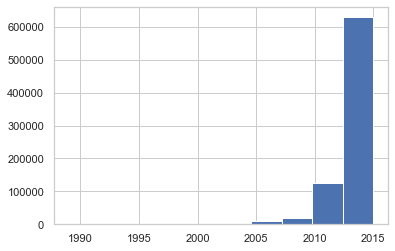

In [181]:
df['accountOpenYear'].hist()

In [182]:
df['transactionYear'].value_counts()

2016    786363
Name: transactionYear, dtype: int64

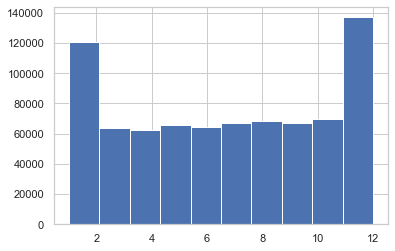

In [183]:
df['transactionMonth'].hist()

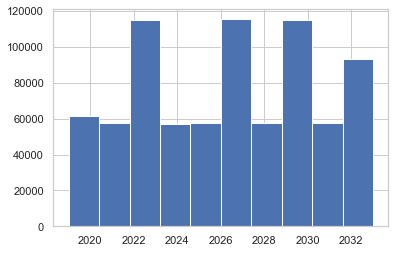

In [184]:
df['currentExpYear'].hist()

Text(0.5, 8.95999999999998, 'Hour of Transaction')

<Figure size 800x560 with 0 Axes>

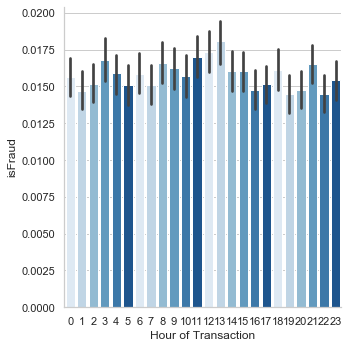

In [202]:
plt.figure(figsize=(10,7), dpi= 80)
sns.catplot(x = 'transactionHour',
            y = 'isFraud',
            data = df,
            kind = 'bar',
            palette = sns.color_palette("Blues"))
plt.xlabel('Hour of Transaction')

Hour of fraudulent transaction might be a potential important variable in fraud detection model.

## - Drop Columns with 100% Missing Values

The six following columns are 100% missing. In the next steps, I propose collecting the missing variables.

In [14]:
df = df.drop(columns = ['recurringAuthInd', 'posOnPremises', 'merchantCity', 'merchantState', 'merchantZip', 'echoBuffer'])

## - Explore Unique IDs

It is important to understand how many unique customers exist and if one customer is mapped to one/multiple accounts.

In [15]:
print('Number of unique Account Numbers= ', df['accountNumber'].nunique())
print('Number of unique Customer IDs= ', df['customerId'].nunique())

Number of unique Account Numbers=  5000
Number of unique Customer IDs=  5000


In [16]:
#Check if each customer has one account number
sum(df.groupby('customerId').accountNumber.nunique()==1)

5000

In [17]:
df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'CVV_match'],
      dtype='object')

# Q2: Plots and Hypotheses

### - Histogram of the processed amounts of each transaction

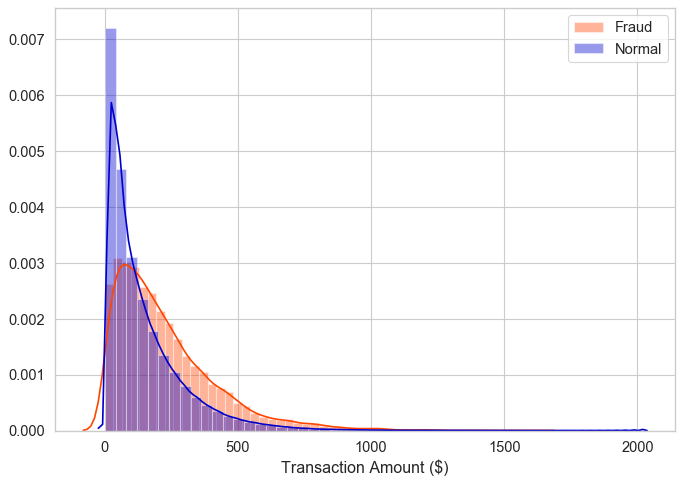

In [414]:
plt.figure(figsize=(10,7), dpi= 80)
sns.set_style('whitegrid')
#sns.set(font_scale = 1.2)
sns.distplot(df[df['isFraud']==True]['transactionAmount'], hist=True, color='orangered',
             label = 'Fraud')
sns.distplot(df[df['isFraud']==False]['transactionAmount'], hist=True, color='mediumblue',
             label = 'Normal')
plt.xlabel('Transaction Amount ($)')
plt.legend()

### - Visualization of selected categorical variables

### - POS Entry Mode

Classes: <br>
- 02: Magnetic stripe read. For Plus transactions, this code also means that the exact Track 2 content is included and CVV checking is possible.
- 09: PAN entry via electronic commerce, including chip.
- 05: Integrated circuit card read; card data reliable.
- 80: Chip card was unable to process/magnetic stripe read default.
- 90: Magnetic stripe read and extract content of Track 1 or Track 2 included (CVV check is possible).

- More Information about pos entry mode is available in the following link
https://www.mreports.com/documentation/ac/nonmerchant/80451.htm

<Figure size 1120x800 with 0 Axes>

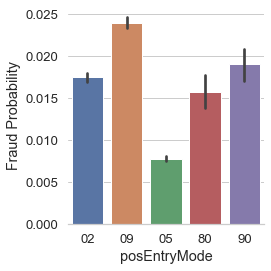

In [420]:
plt.figure(figsize=(14,10), dpi= 80)
sns.set(style="whitegrid", font_scale=1.2)
g = sns.catplot(x = 'posEntryMode', y = 'isFraud', data = df,
                height=4, kind="bar", palette="deep")
g.despine(left=True)
g.set_ylabels("Fraud Probability")
#.set_xticklabels(["Magnetic Stripe Track 2", "PAN entry via electronic commerce", "Integrated Circuit Card Read",  "Chip was unable to process", "Magnetic Stripe Track 1 and 2"], rotation = -45)

### - POS Condition Code

Classes: <br>
- 01: Cardholder not present
- 08: Mail/telephone order (includes Visa phone and reoccurring transactions)
- 09: Definition is not available

More information about pos condition code is available in the following link
https://www.mreports.com/documentation/ac/nonmerchant/80449.htm

<Figure size 1120x800 with 0 Axes>

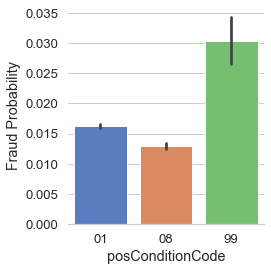

In [421]:
plt.figure(figsize=(14,10), dpi= 80)
sns.set(style="whitegrid", font_scale=1.2)
g1 = sns.catplot(x = 'posConditionCode', y = 'isFraud', data = df,
                height=4, kind="bar", palette="muted")
g1.despine(left=True)
g1.set_ylabels("Fraud Probability")
#.set_xticklabels(["Cardholder not present", "Mail/telephone order", "99"], rotation = 45)

### - Fraud Probability by Merchant Category

<Figure size 1120x800 with 0 Axes>

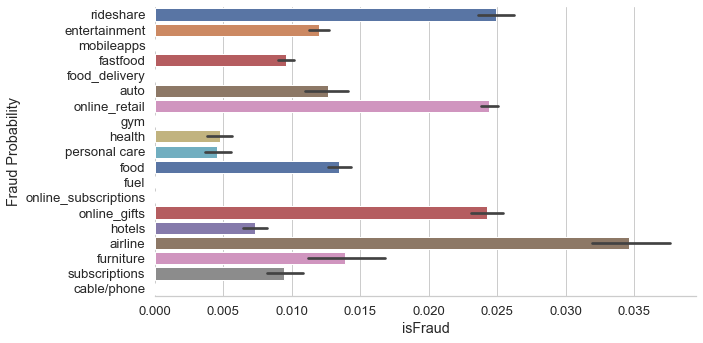

In [422]:
plt.figure(figsize=(14,10), dpi= 80)
sns.set(style="whitegrid", font_scale=1.2)
g2 = sns.catplot(y = 'merchantCategoryCode', x = 'isFraud', data = df,
                height=5, aspect=2 , kind="bar", palette="deep")
g2.despine(left=True)
g2.set_ylabels("Fraud Probability")

### - Additional EDA

In [210]:
df[df['isFraud']==False]['merchantCategoryCode'].value_counts(normalize=True) * 100

online_retail           25.482140
fastfood                14.350355
entertainment           10.225132
food                     9.622894
online_gifts             8.350970
rideshare                6.442827
hotels                   4.373303
fuel                     3.089363
subscriptions            2.931083
auto                     2.762208
health                   2.455210
personal care            2.439188
mobileapps               1.936828
airline                  1.922356
online_subscriptions     1.429945
furniture                0.946965
food_delivery            0.775248
gym                      0.285420
cable/phone              0.178565
Name: merchantCategoryCode, dtype: float64

In [207]:
df[df['isFraud']==True]['merchantCategoryCode'].value_counts(normalize=True) * 100

online_retail    39.768060
online_gifts     12.933881
rideshare        10.244020
fastfood          8.649432
food              8.166224
entertainment     7.739390
airline           4.300556
auto              2.198599
hotels            2.013369
subscriptions     1.739551
furniture         0.829508
health            0.724813
personal care     0.692599
Name: merchantCategoryCode, dtype: float64

In [209]:
df[df['isFraud']==False]['posConditionCode'].value_counts(normalize=True) * 100

01    79.962485
08    19.093308
99     0.944207
Name: posConditionCode, dtype: float64

In [45]:
df[df['isFraud']==True]['posConditionCode'].value_counts(normalize=True) * 100

01    82.533280
08    15.619201
99     1.847519
Name: posConditionCode, dtype: float64

In [208]:
df[df['isFraud']==False]['posEntryMode'].value_counts(normalize=True) * 100

05    40.586189
09    29.970617
02    24.996462
90     2.493505
80     1.953228
Name: posEntryMode, dtype: float64

In [46]:
df[df['isFraud']==True]['posEntryMode'].value_counts(normalize=True) * 100

09    46.583800
02    28.161014
05    20.217320
90     3.062232
80     1.975634
Name: posEntryMode, dtype: float64

### - Fraud Transaction Prob by Transaction Type

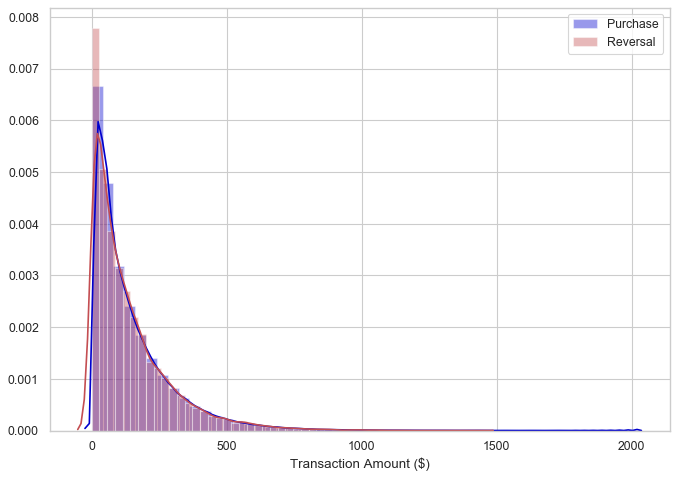

In [217]:
plt.figure(figsize=(10,7), dpi= 80)
'''sns.distplot(df[df['transactionType']=='ADDRESS_VERIFICATION']['transactionAmount'], hist=True, color='r',
             label = 'Address Verification', norm_hist=True)'''
sns.distplot(df[df['transactionType']=='PURCHASE']['transactionAmount'], hist=True, color='mediumblue',
             label = 'Purchase',  norm_hist=True)
sns.distplot(df[df['transactionType']=='REVERSAL']['transactionAmount'], hist=True, color='r',
             label = 'Reversal',  norm_hist=True)
plt.xlabel('Transaction Amount ($)')
plt.legend()

The observed pattern is unlikely to be significant indicator of Fraud transactions.

It looks like some credit card companies allow negative availableMoney is some types of transactions.

In [276]:
df[(df['accountNumber']==556079222)].sort_values(by='availableMoney')

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,CVV_match,acqMerchantCountryMatch,timeSinceOpenDate,timeSinceAddressChange,timeLeftToExp,accountOpenYear,transactionYear,transactionMonth,transactionHour,currentExpYear,transaction_rank_by_customerID,reversal_ind,duplicate_ind,doubleSwipe_ind
746872,746872,556079222,556079222,1000,-1005.63,2016-02-29 01:12:49,407.44,Uber,US,US,9.0,1.0,rideshare,2020-02-01 00:00:00,2013-10-10 00:00:00,2013-10-10 00:00:00,536,536,4052,PURCHASE,2005.63,False,False,False,True,True,872 days 01:12:49.000000000,872 days 01:12:49.000000000,1432 days 22:47:11.000000000,2013,2016,2,1,2020,51.0,False,False,False
746873,746873,556079222,556079222,1000,-882.69,2016-03-02 16:50:53,62.50,Uber,US,US,2.0,1.0,rideshare,2023-02-01 00:00:00,2013-10-10 00:00:00,2013-10-10 00:00:00,733,733,3365,PURCHASE,1882.69,False,False,False,True,True,874 days 16:50:53.000000000,874 days 16:50:53.000000000,2526 days 07:09:07.000000000,2013,2016,3,16,2023,52.0,False,False,False
746948,746948,556079222,556079222,1000,-235.25,2016-06-07 16:33:25,28.80,Sunoco Gas #413153,US,US,9.0,1.0,fuel,2028-07-01 00:00:00,2013-10-10 00:00:00,2013-10-10 00:00:00,536,536,4052,PURCHASE,1235.25,True,False,False,True,True,971 days 16:33:25.000000000,971 days 16:33:25.000000000,4406 days 07:26:35.000000000,2013,2016,6,16,2028,127.0,False,True,False
746899,746899,556079222,556079222,1000,-186.60,2016-04-12 00:36:07,93.35,Lyft,US,US,2.0,8.0,rideshare,2020-05-01 00:00:00,2013-10-10 00:00:00,2013-10-10 00:00:00,536,536,4052,PURCHASE,1186.60,False,False,False,True,True,915 days 00:36:07.000000000,915 days 00:36:07.000000000,1479 days 23:23:53.000000000,2013,2016,4,0,2020,78.0,False,False,False
746930,746930,556079222,556079222,1000,-39.35,2016-05-13 01:45:45,21.36,Lyft,US,US,9.0,1.0,rideshare,2031-01-01 00:00:00,2013-10-10 00:00:00,2013-10-10 00:00:00,733,733,3365,PURCHASE,1039.35,False,False,False,True,True,946 days 01:45:45.000000000,946 days 01:45:45.000000000,5345 days 22:14:15.000000000,2013,2016,5,1,2031,109.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746858,746858,556079222,556079222,1000,1000.00,2016-02-17 11:09:46,199.88,Fresh Online Services,US,US,90.0,1.0,online_gifts,2029-01-01 00:00:00,2013-10-10 00:00:00,2013-10-10 00:00:00,831,831,6986,REVERSAL,0.00,False,False,False,True,True,860 days 11:09:46.000000000,860 days 11:09:46.000000000,4701 days 12:50:14.000000000,2013,2016,2,11,2029,37.0,False,True,False
746859,746859,556079222,556079222,1000,1000.00,2016-02-18 01:27:24,32.98,Lyft,US,US,5.0,1.0,rideshare,2030-08-01 00:00:00,2013-10-10 00:00:00,2013-10-10 00:00:00,733,733,3365,PURCHASE,0.00,False,False,False,True,True,861 days 01:27:24.000000000,861 days 01:27:24.000000000,5277 days 22:32:36.000000000,2013,2016,2,1,2030,38.0,False,False,False
747018,747018,556079222,556079222,1000,1000.00,2016-08-20 02:48:50,146.00,Uber,US,US,90.0,1.0,rideshare,2024-10-01 00:00:00,2013-10-10 00:00:00,2013-10-10 00:00:00,831,831,6986,PURCHASE,0.00,False,False,False,True,True,1045 days 02:48:50.000000000,1045 days 02:48:50.000000000,2963 days 21:11:10.000000000,2013,2016,8,2,2024,197.0,False,False,False
746978,746978,556079222,556079222,1000,1000.00,2016-07-12 22:13:52,52.90,Next Day eCards,US,US,5.0,1.0,online_gifts,2027-01-01 00:00:00,2013-10-10 00:00:00,2013-10-10 00:00:00,733,733,3365,PURCHASE,0.00,False,False,False,True,True,1006 days 22:13:52.000000000,1006 days 22:13:52.000000000,3824 days 01:46:08.000000000,2013,2016,7,22,2027,157.0,False,False,False


# Q3: Data Wrangling

## - Generate Transaction Ranking by Customer ID

In [242]:
transaction_rank_by_customerID = df.groupby('customerId')['transactionDateTime'].rank('dense', ascending=True)
df['transaction_rank_by_customerID'] = df.groupby('customerId')['transactionDateTime'].rank('dense', ascending=True)

In [28]:
df[df['accountNumber']==114896048]
#863358589, 114896048, 984504651 accountNumber

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,customerId,dateOfLastAddressChange,echoBuffer,enteredCVV,expirationDateKeyInMatch,isFraud,merchantCategoryCode,merchantCity,merchantCountryCode,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionAmount,transactionDateTime,transactionType,transaction_rank_by_customerID
968,114896048,2015-12-19,US,15000.00,773,8915,False,15000,0.00,01/2021,114896048,2015-12-19,NaN,773,False,False,online_retail,NaN,US,cheapfast.com,NaN,NaN,01,05,NaN,NaN,288.77,2016-01-01 17:50:18,PURCHASE,1.0
969,114896048,2015-12-19,US,14711.23,773,8915,False,15000,288.77,02/2027,114896048,2015-12-19,NaN,773,False,False,rideshare,NaN,US,Uber,NaN,NaN,01,02,NaN,NaN,355.60,2016-01-02 18:04:02,PURCHASE,2.0
970,114896048,2015-12-19,US,14355.63,773,8915,False,15000,644.37,11/2030,114896048,2015-12-19,NaN,773,False,False,online_retail,NaN,US,cheapfast.com,NaN,NaN,01,09,NaN,NaN,241.67,2016-01-06 05:41:42,PURCHASE,3.0
971,114896048,2015-12-19,US,14113.96,773,8915,False,15000,886.04,09/2028,114896048,2015-12-19,NaN,773,False,True,online_retail,NaN,US,sears.com,NaN,NaN,01,09,NaN,NaN,298.85,2016-01-06 08:05:06,PURCHASE,4.0
972,114896048,2015-12-19,US,13815.11,773,8915,False,15000,1184.89,09/2030,114896048,2015-12-19,NaN,773,False,False,online_retail,NaN,US,cheapfast.com,NaN,NaN,01,09,NaN,NaN,44.68,2016-01-07 07:05:28,PURCHASE,5.0
973,114896048,2015-12-19,US,13770.43,773,8915,False,15000,1229.57,04/2027,114896048,2015-12-19,NaN,773,False,False,online_retail,NaN,US,amazon.com,NaN,NaN,01,05,NaN,NaN,45.17,2016-01-08 12:40:37,PURCHASE,6.0
974,114896048,2015-12-19,US,13725.26,773,8915,False,15000,1274.74,05/2022,114896048,2015-12-19,NaN,773,False,False,online_retail,NaN,US,apple.com,NaN,NaN,08,09,NaN,NaN,196.57,2016-01-08 16:29:45,PURCHASE,7.0
975,114896048,2015-12-19,US,13528.69,773,8915,False,15000,1471.31,08/2022,114896048,2015-12-19,NaN,773,False,False,rideshare,NaN,US,Uber,NaN,NaN,01,02,NaN,NaN,256.18,2016-01-09 00:27:26,PURCHASE,8.0
976,114896048,2015-12-19,US,13272.51,773,8915,False,15000,1727.49,05/2021,114896048,2015-12-19,NaN,773,False,False,online_retail,NaN,US,staples.com,NaN,NaN,01,09,NaN,NaN,46.71,2016-01-09 04:45:03,PURCHASE,9.0
977,114896048,2015-12-19,US,13225.80,773,8915,False,15000,1774.20,07/2027,114896048,2015-12-19,NaN,773,False,False,rideshare,NaN,US,Lyft,NaN,NaN,01,02,NaN,NaN,90.25,2016-01-10 08:10:31,PURCHASE,10.0


## - Identify duplicate, double swipe and reversal transactions

- Duplicate Transaction
    - Non-zero transaction amount
    - Equal transaction amount
    - Similar customer ID
    - Similar merchant name
    - Similar merchant country code
    - Happened after the identical transaction <br>
- Double Swipe Transaction
    - Non-zero transaction amount
    - Not a reversal transaction (doesn't increase the available money)
    - Happens within 5 minutes of its identical transaction
- Reversal Transaction
    - Non-zero transaction amount
    - Increases the available money of the subsequent transaction by its value

In [547]:
#function to determine double swipe transactions
def duplicateTransaction(df, row, index):
    this_customerId = row['customerId']
    this_ranking = row['transaction_rank_by_customerID']
    this_merchantName = row['merchantName']
    this_merchantCountryCode = row['merchantCountryCode']
    this_transaction_time = row['transactionDateTime']
    this_transactionAmount = row['transactionAmount']
    this_availableMoney = float(row['availableMoney'])
    
    #subset of customerID without address changes
    sub_df = df[(df['customerId']==this_customerId)]
    
    #subset of similar transactions
    similar_transactions = sub_df[(sub_df['merchantName']==this_merchantName) &
                             (sub_df['merchantCountryCode']==this_merchantCountryCode) &
                             (this_transaction_time > sub_df['transactionDateTime']) &
                             (sub_df['transaction_rank_by_customerID'] < this_ranking) &
                             (sub_df['transactionAmount'] == this_transactionAmount) ] #the row itself is not included
    #Duplicate Transactions
    if len(similar_transactions)>0 and this_transactionAmount!=0:
        duplicate  = True
    else:
        duplicate = False

    #Reversal transactions
    next_transaction = sub_df[sub_df['transaction_rank_by_customerID']==(this_ranking+1)]
    if next_transaction.empty==False:
        next_transaction = next_transaction.iloc[0]
    '''print(next_transaction)
    print(this_ranking)
    print((sub_df['transaction_rank_by_customerID']==(this_ranking + 1)))
    print(round(next_transaction['availableMoney'],0))
    print(round(this_availableMoney + this_transactionAmount, 0))'''
    
    if next_transaction.empty==False and (this_transactionAmount!=0) and (round(next_transaction['availableMoney'],2) == round(this_availableMoney + this_transactionAmount, 2)):
        reversal = True
        doubleSwipe = False
    else:
        reversal = False
        #Double Swipe Transactions
        if this_transactionAmount!=0 and len(similar_transactions[this_transaction_time - timedelta(days=0, hours=0, minutes=5) < similar_transactions['transactionDateTime']]) >= 1:
            doubleSwipe = True
        else:
            doubleSwipe = False
    #print('reversal',reversal)
    output = (duplicate, doubleSwipe, reversal)
    return output

In [549]:
reversal_ind = []
duplicate_ind = []
doubleSwipe_ind = []
#test = df[0:100]
for index, row in df.iterrows():
    #print('**', index)
    if index%100==0:
        print(index)
    d = duplicateTransaction(df, row, index)
    duplicate_ind.append(d[0])
    reversal_ind.append(d[2])
    doubleSwipe_ind.append(d[1])
    
df['reversal_ind'] = reversal_ind
df['duplicate_ind'] = duplicate_ind
df['doubleSwipe_ind'] = doubleSwipe_ind

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

250100
250200
250300
250400
250500
250600
250700
250800
250900
251000
251100
251200
251300
251400
251500
251600
251700
251800
251900
252000
252100
252200
252300
252400
252500
252600
252700
252800
252900
253000
253100
253200
253300
253400
253500
253600
253700
253800
253900
254000
254100
254200
254300
254400
254500
254600
254700
254800
254900
255000
255100
255200
255300
255400
255500
255600
255700
255800
255900
256000
256100
256200
256300
256400
256500
256600
256700
256800
256900
257000
257100
257200
257300
257400
257500
257600
257700
257800
257900
258000
258100
258200
258300
258400
258500
258600
258700
258800
258900
259000
259100
259200
259300
259400
259500
259600
259700
259800
259900
260000
260100
260200
260300
260400
260500
260600
260700
260800
260900
261000
261100
261200
261300
261400
261500
261600
261700
261800
261900
262000
262100
262200
262300
262400
262500
262600
262700
262800
262900
263000
263100
263200
263300
263400
263500
263600
263700
263800
263900
264000
264100
264200
264300

367200
367300
367400
367500
367600
367700
367800
367900
368000
368100
368200
368300
368400
368500
368600
368700
368800
368900
369000
369100
369200
369300
369400
369500
369600
369700
369800
369900
370000
370100
370200
370300
370400
370500
370600
370700
370800
370900
371000
371100
371200
371300
371400
371500
371600
371700
371800
371900
372000
372100
372200
372300
372400
372500
372600
372700
372800
372900
373000
373100
373200
373300
373400
373500
373600
373700
373800
373900
374000
374100
374200
374300
374400
374500
374600
374700
374800
374900
375000
375100
375200
375300
375400
375500
375600
375700
375800
375900
376000
376100
376200
376300
376400
376500
376600
376700
376800
376900
377000
377100
377200
377300
377400
377500
377600
377700
377800
377900
378000
378100
378200
378300
378400
378500
378600
378700
378800
378900
379000
379100
379200
379300
379400
379500
379600
379700
379800
379900
380000
380100
380200
380300
380400
380500
380600
380700
380800
380900
381000
381100
381200
381300
381400

484300
484400
484500
484600
484700
484800
484900
485000
485100
485200
485300
485400
485500
485600
485700
485800
485900
486000
486100
486200
486300
486400
486500
486600
486700
486800
486900
487000
487100
487200
487300
487400
487500
487600
487700
487800
487900
488000
488100
488200
488300
488400
488500
488600
488700
488800
488900
489000
489100
489200
489300
489400
489500
489600
489700
489800
489900
490000
490100
490200
490300
490400
490500
490600
490700
490800
490900
491000
491100
491200
491300
491400
491500
491600
491700
491800
491900
492000
492100
492200
492300
492400
492500
492600
492700
492800
492900
493000
493100
493200
493300
493400
493500
493600
493700
493800
493900
494000
494100
494200
494300
494400
494500
494600
494700
494800
494900
495000
495100
495200
495300
495400
495500
495600
495700
495800
495900
496000
496100
496200
496300
496400
496500
496600
496700
496800
496900
497000
497100
497200
497300
497400
497500
497600
497700
497800
497900
498000
498100
498200
498300
498400
498500

601400
601500
601600
601700
601800
601900
602000
602100
602200
602300
602400
602500
602600
602700
602800
602900
603000
603100
603200
603300
603400
603500
603600
603700
603800
603900
604000
604100
604200
604300
604400
604500
604600
604700
604800
604900
605000
605100
605200
605300
605400
605500
605600
605700
605800
605900
606000
606100
606200
606300
606400
606500
606600
606700
606800
606900
607000
607100
607200
607300
607400
607500
607600
607700
607800
607900
608000
608100
608200
608300
608400
608500
608600
608700
608800
608900
609000
609100
609200
609300
609400
609500
609600
609700
609800
609900
610000
610100
610200
610300
610400
610500
610600
610700
610800
610900
611000
611100
611200
611300
611400
611500
611600
611700
611800
611900
612000
612100
612200
612300
612400
612500
612600
612700
612800
612900
613000
613100
613200
613300
613400
613500
613600
613700
613800
613900
614000
614100
614200
614300
614400
614500
614600
614700
614800
614900
615000
615100
615200
615300
615400
615500
615600

718500
718600
718700
718800
718900
719000
719100
719200
719300
719400
719500
719600
719700
719800
719900
720000
720100
720200
720300
720400
720500
720600
720700
720800
720900
721000
721100
721200
721300
721400
721500
721600
721700
721800
721900
722000
722100
722200
722300
722400
722500
722600
722700
722800
722900
723000
723100
723200
723300
723400
723500
723600
723700
723800
723900
724000
724100
724200
724300
724400
724500
724600
724700
724800
724900
725000
725100
725200
725300
725400
725500
725600
725700
725800
725900
726000
726100
726200
726300
726400
726500
726600
726700
726800
726900
727000
727100
727200
727300
727400
727500
727600
727700
727800
727900
728000
728100
728200
728300
728400
728500
728600
728700
728800
728900
729000
729100
729200
729300
729400
729500
729600
729700
729800
729900
730000
730100
730200
730300
730400
730500
730600
730700
730800
730900
731000
731100
731200
731300
731400
731500
731600
731700
731800
731900
732000
732100
732200
732300
732400
732500
732600
732700

### - Some Sanity Checks

In [518]:
index

14266

In [377]:
len(reversal_ind)

262252

In [389]:
len(duplicate_ind)

786363

In [390]:
len(doubleSwipe_ind)

786363

In [380]:
len(df[0:index])

262252

*Note:* If you want to save the results (generating them might take some time depending on the computing power), you can change the following path.

In [550]:
df.to_csv('/transactions/dfQ3.csv')

*Note:* If you do not want to generate the flags again, just load it from the CSV file.

In [93]:
df = pd.read_csv('/transactions/dfQ3.csv')

In [552]:
pd.crosstab(df['doubleSwipe_ind'], df['duplicate_ind'])

duplicate_ind,False,True
doubleSwipe_ind,,
False,719132,59335
True,0,7896


In [553]:
pd.crosstab(df['doubleSwipe_ind'], df['reversal_ind'])

reversal_ind,False,True
doubleSwipe_ind,,
False,760775,17692
True,7896,0


### - Total Number of Transactions and Total Dollar Amounts

In [554]:
#Reversal transactions by transaction type
print('Number of Reversal Transactions')
print(len(df[df['transactionType']=='REVERSAL']))
print(len(df[df['transactionType']=='REVERSAL'])/len(df)*100)
print('Total transaction amount of reversal transactions')
print(sum(df[df['transactionType']=='REVERSAL']['transactionAmount']))

Number of Reversal Transactions
20303
2.581886482451489
Total transaction amount of reversal transactions
2821792.4999999753


In [95]:
print('Number of Double Swipe Transactions')
print(len(df[df['doubleSwipe_ind']==True]))
print(len(df[df['doubleSwipe_ind']==True])/len(df)*100)
print('Total transaction amount of double swipe transactions')
print(sum(df[df['doubleSwipe_ind']==True]['transactionAmount']))

Number of Double Swipe Transactions
7896
1.0041164195161776
Total transaction amount of double swipe transactions
1193590.3199999959


In [96]:
#Reversal transactions identified by the function
print('Number of Reversal Transactions')
print(len(df[df['reversal_ind']==True]))
print(len(df[df['reversal_ind']==True])/len(df)*100)
print('Total transaction amount of reversal transactions')
print(sum(df[df['reversal_ind']==True]['transactionAmount']))

Number of Reversal Transactions
17692
2.2498515316717596
Total transaction amount of reversal transactions
2431480.6299999887


In [248]:
avgTransactionAmount_df = {'transactionType': ['Reversal', 'Double-Swipe'],
                         'avgTransactionAmount': [df[df['transactionType'] == 'REVERSAL']['transactionAmount'].mean(),
                                                 df[df['doubleSwipe_ind'] == True]['transactionAmount'].mean()],
                        'SE': [df[df['transactionType'] == 'REVERSAL']['transactionAmount'].sem(),
                                                 df[df['doubleSwipe_ind'] == True]['transactionAmount'].sem()]}

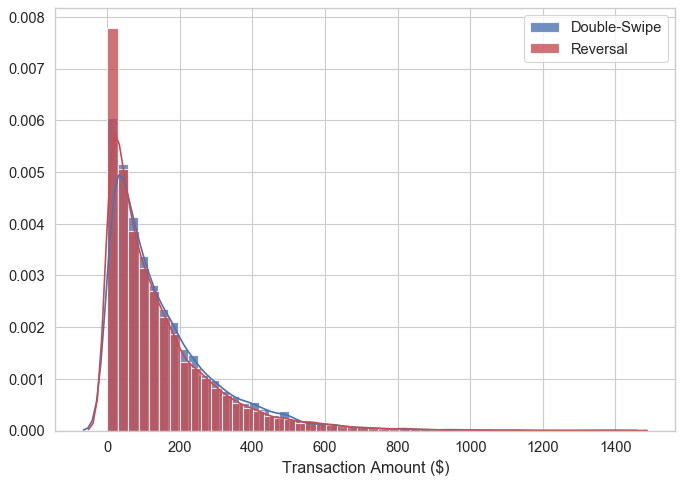

In [267]:
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(df[df['doubleSwipe_ind']== True]['transactionAmount'], hist=True, color='b',
             label = 'Double-Swipe',  norm_hist=True, hist_kws=dict(alpha=0.8))
sns.distplot(df[df['transactionType']=='REVERSAL']['transactionAmount'], hist=True, color='r',
             label = 'Reversal',  norm_hist=True, hist_kws=dict(alpha=0.8))
plt.xlabel('Transaction Amount ($)')
plt.legend()

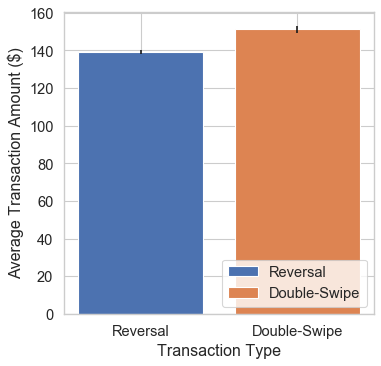

In [252]:
plt.figure(figsize=(5,5), dpi= 80)
ax = plt.subplot(1,1,1)
ax.bar(avgTransactionAmount_df['transactionType'][0],avgTransactionAmount_df['avgTransactionAmount'][0],
       yerr=avgTransactionAmount_df['SE'][0])
ax.bar(avgTransactionAmount_df['transactionType'][1],avgTransactionAmount_df['avgTransactionAmount'][1],
       yerr=avgTransactionAmount_df['SE'][1])
plt.ylabel('Average Transaction Amount ($)')
plt.xlabel('Transaction Type')
plt.legend(['Reversal', 'Double-Swipe'], loc='lower right')
plt.show()

# Q4: Fraud Detection Model

## - Sliding-Window Features

We define a time window of the previous X days or Y transactions to capture the normal behavioral pattern of each account. The number of days or number of transactions can be iterated to find the optimum window. <br>
- Cons of # of days: Might not find any transaction in the last X days
- Cons of # of transactions: Y transactions can be old transactions if there is not too much activity on the account.<br>
Here, for the first round of analysis, I considered the previous 3 transactions.

In [556]:
unique_account_numbers = df['accountNumber'].unique()
print('There are', len(unique_account_numbers), 'unique account number in the dataset.')

There are 5000 unique account number in the dataset.


Next, I iterate over the account numbers and define the following features based on the previous 3 transactions.<br>
- merchantCategoryCode (top 6 categories with highest number of fraudulant transactions
- merchantCountryCode
- isFraud (if any other fraudulant activity has happened in the time window
- expirationDateKeyInMatch
- CVV_match
- cardPresent
- posConditionCode
- posEntryMode

The following code takes sometime to iterate over the windows. I have saved it to a file. You can skip running this and use the saved csv file.

In [557]:
#length of sliding window is seven days
#window_len = timedelta(7)
#length of sliding window is three transactions
window_len = 3
new_df = pd.DataFrame()
c=0
for acnt_num in unique_account_numbers:
    max_transaction_amount = []
    min_transaction_amount = []
    average_transaction_amount = []
    window_isFraud = []
    window_CVV_match = []
    window_expirationDateKeyInMatch = []
    window_cardPresent = []
    window_merchant_US = []
    window_merchant_Canada = []
    window_merchant_Mexico = []
    window_merchant_PR = []
    window_online_retail = []
    window_online_gift = []
    window_rideshare = []
    window_fastfood = []
    window_food = []
    window_airline = []
    print(c)
    c += 1
    # subset the transactions for the current account number
    df_subset = df[df['accountNumber'] == acnt_num]
    
    for i in range(0,len(df_subset)):
        row = df_subset.iloc[i]
        #this_transaction_datetime = row['transactionDateTime']
        this_transaction_rank = row['transaction_rank_by_customerID']
        window = df_subset[(df_subset['transaction_rank_by_customerID'] < this_transaction_rank) &
                          (df_subset['transaction_rank_by_customerID'] >= (this_transaction_rank - window_len))]
        max_transaction_amount.append(window['transactionAmount'].max())
        min_transaction_amount.append(window['transactionAmount'].min())
        average_transaction_amount.append(window['transactionAmount'].mean())
        window_isFraud.append(sum(window['isFraud'] == True))
        window_CVV_match.append(sum(window['CVV_match'] == False))
        window_expirationDateKeyInMatch.append(sum(window['expirationDateKeyInMatch'] == False))
        window_cardPresent.append(sum(window['cardPresent'] == False))
        window_merchant_US.append(sum(window['merchantCountryCode'] == 'US'))
        window_merchant_Canada.append(sum(window['merchantCountryCode'] == 'CAN'))
        window_merchant_Mexico.append(sum(window['merchantCountryCode'] == 'MEX'))
        window_merchant_PR.append(sum(window['merchantCountryCode'] == 'PR'))
        window_online_retail.append(sum(window['merchantCategoryCode'] == 'online_retail'))
        window_online_gift.append(sum(window['merchantCategoryCode'] == 'online_gift'))
        window_rideshare.append(sum(window['merchantCategoryCode'] == 'rideshare'))
        window_fastfood.append(sum(window['merchantCategoryCode'] == 'fastfood'))
        window_food.append(sum(window['merchantCategoryCode'] == 'food'))
        window_airline.append(sum(window['merchantCategoryCode'] == 'airline'))
        
    #add window variables to the dataframe    
    df_subset['max_transaction_amount'] = max_transaction_amount
    df_subset['min_transaction_amount'] = min_transaction_amount
    df_subset['average_transaction_amount'] = average_transaction_amount
    df_subset['window_isFraud'] = window_isFraud
    df_subset['window_CVV_match'] = window_CVV_match
    df_subset['window_expirationDateKeyInMatch'] = window_expirationDateKeyInMatch
    df_subset['window_cardPresent'] = window_cardPresent
    df_subset['window_merchant_US'] = window_merchant_US
    df_subset['window_merchant_Canada'] = window_merchant_Canada
    df_subset['window_merchant_Mexico'] = window_merchant_Mexico
    df_subset['window_merchant_PR'] = window_merchant_PR
    df_subset['window_online_retail'] = window_online_retail
    df_subset['window_online_gift'] = window_online_gift
    df_subset['window_rideshare'] = window_rideshare
    df_subset['window_fastfood'] = window_fastfood
    df_subset['window_food'] = window_food
    df_subset['window_airline'] = window_airline
    
    #create a new dataframe with the window features
    if new_df.empty == False:
        new_df = new_df.append(df_subset)
    elif new_df.empty:
        new_df = df_subset
            

0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [561]:
df.shape

(786363, 37)

In [562]:
new_df.shape

(786363, 54)

In [563]:
new_df.to_csv('/transactions/transactions_window_features_3transactions.csv')

*Note:* Creating the window variables might take sometime. Use the saved csv file which contains the window variable to continue the analysis.

In [5]:
new_df = pd.read_csv('/transactions/transactions_window_features_3transactions.csv')

In [42]:
new_df.head(10)

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,CVV_match,acqMerchantCountryMatch,timeSinceOpenDate,timeSinceAddressChange,timeLeftToExp,accountOpenYear,transactionYear,transactionMonth,transactionHour,currentExpYear,transaction_rank_by_customerID,reversal_ind,duplicate_ind,doubleSwipe_ind,max_transaction_amount,min_transaction_amount,average_transaction_amount,window_isFraud,window_CVV_match,window_expirationDateKeyInMatch,window_cardPresent,window_merchant_US,window_merchant_Canada,window_merchant_Mexico,window_merchant_PR,window_online_retail,window_online_gift,window_rideshare,window_fastfood,window_food,window_airline
0,0,737265056,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,2.0,1.0,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.00,False,False,False,True,True,518 days 14:27:32.000000000,518 days 14:27:32.000000000,2482 days 09:32:28.000000000,2015,2016,8,14,2023,1.0,False,False,False,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,737265056,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,9.0,1.0,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,True,False,False,True,True,577 days 05:05:54.000000000,577 days 05:05:54.000000000,2668 days 18:54:06.000000000,2015,2016,10,5,2024,2.0,False,False,False,98.55,98.55,98.550000,0,0,1,1,1,0,0,0,0,0,1,0,0,0
2,2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,9.0,1.0,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False,True,True,605 days 09:18:39.000000000,605 days 09:18:39.000000000,3187 days 14:41:21.000000000,2015,2016,11,9,2025,3.0,False,False,False,98.55,74.51,86.530000,0,0,2,1,2,0,0,0,0,0,1,0,0,0
3,3,737265056,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,9.0,1.0,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False,True,True,637 days 02:14:50.000000000,637 days 02:14:50.000000000,3155 days 21:45:10.000000000,2015,2016,12,2,2025,4.0,False,True,False,98.55,7.47,60.176667,0,0,3,2,3,0,0,0,0,0,1,0,0,0
4,4,830329091,830329091,5000,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,2.0,1.0,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,False,True,True,231 days 21:04:46.000000000,231 days 21:04:46.000000000,4938 days 02:55:14.000000000,2015,2016,3,21,2029,1.0,False,False,False,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,830329091,830329091,5000,5000.00,2016-04-19 16:24:27,30.76,In-N-Out #422833,US,US,2.0,1.0,fastfood,2020-01-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,False,True,True,257 days 16:24:27.000000000,257 days 16:24:27.000000000,1351 days 07:35:33.000000000,2015,2016,4,16,2020,2.0,False,False,False,71.18,71.18,71.180000,0,0,1,0,1,0,0,0,0,0,0,1,0,0
6,6,830329091,830329091,5000,5000.00,2016-05-21 14:50:35,57.28,Krispy Kreme #685312,US,US,2.0,1.0,fastfood,2020-05-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,False,True,True,289 days 14:50:35.000000000,289 days 14:50:35.000000000,1440 days 09:09:25.000000000,2015,2016,5,14,2020,3.0,False,False,False,71.18,30.76,50.970000,0,0,2,0,2,0,0,0,0,0,0,2,0,0
7,7,830329091,830329091,5000,5000.00,2016-06-03 00:31:21,9.37,Shake Shack #968081,US,US,5.0,1.0,fastfood,2021-01-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,False,True,True,302 days 00:31:21.000000000,302 days 00:31:21.000000000,1672 days 23:28:39.000000000,2015,2016,6,0,2021,4.0,False,False,False,71.18,30.76,53.073333,0,0,3,0,3,0,0,0,0,0,0,3,0,0
8,8,830329091,830329091,5000,4990.63,2016-06-10 01:21:46,523.67,Burger King #486122,NaN,US,2.0,1.0,fastfood,2032-08-01,2015-08-06,2015-08-06,885,885,3143

### - Target Variable

In [6]:
Y = pd.factorize(new_df['isFraud'])[0]
print(sum(Y==1))

12417


### - Features

In [7]:
features = ['transactionAmount', #num 1
            'availableMoney', #num 2
            'creditLimit', #num 3
            'currentBalance', #num 4
            'acqCountry', #cat 1
            'cardPresent', #cat 2
            'expirationDateKeyInMatch', #cat 3
            'merchantCategoryCode', #cat 4
            'merchantCountryCode', #cat 5
            'merchantName', #cat 6
            'posConditionCode', #cat 7
            'posEntryMode', #cat 8
            'transactionType', #cat 9
            'CVV_match', #cat 10
            'acqMerchantCountryMatch', #cat 11
            'timeSinceOpenDate', #num 5
            'timeSinceAddressChange', #num 6
            'timeLeftToExp', #num 7
            'transactionHour', #cat 12
            'transactionMonth', #cat 13
            'doubleSwipe_ind', #cat 14
            'reversal_ind', #cat 15
            'duplicate_ind', #cat 16
            #Window Features
            #All numerical feature from 1-3 if we use 3 previous transactions
            #Can get higher numbers if we use time window
            #num +17
            'max_transaction_amount',
            'min_transaction_amount', 
            'average_transaction_amount', 
            'window_isFraud',
            'window_CVV_match',
            'window_expirationDateKeyInMatch',
            'window_cardPresent',
            'window_merchant_US',
            'window_merchant_Canada',
            'window_merchant_Mexico',
            'window_merchant_PR',
            'window_online_retail',
            'window_online_gift',
            'window_rideshare',
            'window_fastfood',
            'window_food',
            'window_airline']
print(len(features))

40


In [43]:
X = new_df[features]
print(X.shape)

(786363, 40)


### - Missing Values

In [44]:
X.isna().sum()

transactionAmount                     0
availableMoney                        0
creditLimit                           0
currentBalance                        0
acqCountry                         4562
cardPresent                           0
expirationDateKeyInMatch              0
merchantCategoryCode                  0
merchantCountryCode                 724
merchantName                          0
posConditionCode                    409
posEntryMode                       4054
transactionType                     698
CVV_match                             0
acqMerchantCountryMatch               0
timeSinceOpenDate                     0
timeSinceAddressChange                0
timeLeftToExp                         0
transactionHour                       0
transactionMonth                      0
doubleSwipe_ind                       0
reversal_ind                          0
duplicate_ind                         0
max_transaction_amount             5000
min_transaction_amount             5000


*Question:* Are the missing values disproportionately distributed between the classes of target variable?

In [45]:
new_df[new_df['isFraud']==True]['posEntryMode'].isna().sum() / sum(new_df['isFraud']==True)

0.021663847950390593

In [11]:
new_df[new_df['isFraud']==False]['posEntryMode'].isna().sum() / sum(new_df['isFraud']==False)

0.0048905220777677

In [12]:
new_df[new_df['isFraud']==True]['posConditionCode'].isna().sum() / sum(new_df['isFraud']==True)

0.0017717645163888218

In [13]:
new_df[new_df['isFraud']==False]['posConditionCode'].isna().sum() / sum(new_df['isFraud']==False)

0.000500034886154848

In [14]:
new_df[new_df['isFraud']==True]['transactionType'].isna().sum() / sum(new_df['isFraud']==True)

0.0011274865104292503

In [15]:
new_df[new_df['isFraud']==False]['transactionType'].isna().sum() / sum(new_df['isFraud']==False)

0.0008837825894829872

In [16]:
print('Ratio of missing merchantCountryCode for fraudulant transactions')
new_df[new_df['isFraud']==True]['merchantCountryCode'].isna().sum() / sum(new_df['isFraud']==True)

Ratio of missing merchantCountryCode for fraudulant transactions


0.006603849561085609

In [17]:
print('Ratio of missing merchantCountryCode for legitimate transactions')
new_df[new_df['isFraud']==False]['merchantCountryCode'].isna().sum() / sum(new_df['isFraud']==False)

Ratio of missing merchantCountryCode for legitimate transactions


0.0008295152374971897

In [18]:
print('Ratio of missing acqCountry for fraudulant transactions')
new_df[new_df['isFraud']==True]['acqCountry'].isna().sum() / sum(new_df['isFraud']==True)

Ratio of missing acqCountry for fraudulant transactions


0.01199967786099702

In [19]:
print('Ratio of missing acqCountry for legitimate transactions')
new_df[new_df['isFraud']==False]['acqCountry'].isna().sum() / sum(new_df['isFraud']==False)

Ratio of missing acqCountry for legitimate transactions


0.00570194819793629

*Note:* The proportion of missing values in fraudulent transactions are higher than normal transactions. So, we define a new category called missing. There is a potential that missingness represents fraud.

In [46]:
X['posConditionCode'] = X['posConditionCode'].replace(np.nan, 'Missing', regex=True)
X['posEntryMode'] = X['posEntryMode'].replace(np.nan, 'Missing', regex=True)
X['transactionType'] = X['transactionType'].replace(np.nan, 'Missing', regex=True)
X['merchantCountryCode'] = X['merchantCountryCode'].replace(np.nan, 'Missing', regex=True)
X['acqCountry'] = X['acqCountry'].replace(np.nan, 'Missing', regex=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [47]:
X.isna().sum()

transactionAmount                     0
availableMoney                        0
creditLimit                           0
currentBalance                        0
acqCountry                            0
cardPresent                           0
expirationDateKeyInMatch              0
merchantCategoryCode                  0
merchantCountryCode                   0
merchantName                          0
posConditionCode                      0
posEntryMode                          0
transactionType                       0
CVV_match                             0
acqMerchantCountryMatch               0
timeSinceOpenDate                     0
timeSinceAddressChange                0
timeLeftToExp                         0
transactionHour                       0
transactionMonth                      0
doubleSwipe_ind                       0
reversal_ind                          0
duplicate_ind                         0
max_transaction_amount             5000
min_transaction_amount             5000


In [22]:
X['posEntryMode'].value_counts()

5.0        315035
9.0        236481
2.0        195934
90.0        19576
80.0        15283
Missing      4054
Name: posEntryMode, dtype: int64

*Note:* The first transaction of each customer does not have max/min/average transaction amount. As a temporary solution, I replace the variables with the transaction amount of the first row.

In [48]:
#Temporary piece of code, find a better solution later
X['max_transaction_amount'] = X['max_transaction_amount'].fillna(X['transactionAmount'])
X['min_transaction_amount'] = X['min_transaction_amount'].fillna(X['transactionAmount'])
X['average_transaction_amount'] = X['average_transaction_amount'].fillna(X['transactionAmount'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

### - OneHotEncoding

In [24]:
cat_features = [
            'acqCountry', #cat 1
            'cardPresent', #cat 2
            'expirationDateKeyInMatch', #cat 3
            'merchantCategoryCode', #cat 4
            'merchantCountryCode', #cat 5
            #'merchantName', #cat 6
            'posConditionCode', #cat 7
            'posEntryMode', #cat 8
            'transactionType', #cat 9
            'CVV_match', #cat 10
            'acqMerchantCountryMatch', #cat 11
            'transactionHour', #cat 12
            'transactionMonth', #cat 13
            'doubleSwipe_ind', #cat 14
            'reversal_ind', #cat 15
            'duplicate_ind', #cat 16
               ]
print(len(cat_features))

15


In [25]:
oneHotEncoded_cat_features = pd.get_dummies(X[cat_features])
oneHotEncoded_cat_features.shape

(786363, 52)

In [26]:
oneHotEncoded_cat_features.head(10)

,cardPresent,expirationDateKeyInMatch,CVV_match,acqMerchantCountryMatch,transactionHour,transactionMonth,doubleSwipe_ind,reversal_ind,duplicate_ind,acqCountry_CAN,acqCountry_MEX,acqCountry_Missing,acqCountry_PR,acqCountry_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_Missing,merchantCountryCode_PR,merchantCountryCode_US,posConditionCode_1.0,posConditionCode_8.0,posConditionCode_99.0,posConditionCode_Missing,posEntryMode_2.0,posEntryMode_5.0,posEntryMode_9.0,posEntryMode_80.0,posEntryMode_90.0,posEntryMode_Missing,transactionType_ADDRESS_VERIFICATION,transactionType_Missing,transactionType_PURCHASE,transactionType_REVERSAL
0,False,False,True,True,14,8,False,False,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
1,True,False,True,True,5,10,False,False,False,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,False,False,True,True,9,11,False,False,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,False,False,True,True,2,12,False,False,True,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,True,False,True,True,21,3,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
5,True,False,True,True,16,4,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
6,True,False,True,True,14,5,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
7,True,False,True,True,0,6,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0
8,True,False,True,False,1,6,False,False,False,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
9,True,False,True,True,10,7,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0


### - Add numerical features to the oneHotEncoded features

In [27]:
numerical_features = [
            'transactionAmount', #num 1
            'availableMoney', #num 2
            'creditLimit', #num 3
            'currentBalance', #num 4
            'timeSinceOpenDate', #num 5
            'timeSinceAddressChange', #num 6
            'timeLeftToExp', #num 7
            'max_transaction_amount',
            'min_transaction_amount', 
            'average_transaction_amount', 
            'window_isFraud',
            'window_CVV_match',
            'window_expirationDateKeyInMatch',
            'window_cardPresent',
            'window_merchant_US',
            'window_merchant_Canada',
            'window_merchant_Mexico',
            'window_merchant_PR',
            'window_online_retail',
            'window_online_gift',
            'window_rideshare',
            'window_fastfood',
            'window_food',
            'window_airline']

print(len(numerical_features))

24


In [52]:
#Some Sanity Check
[int(i.split(' ')[0]) for i in X['timeSinceOpenDate'][0:10]]

[518, 577, 605, 637, 231, 257, 289, 302, 309, 340]

In [53]:
#if data is read from the csv file run the below code
X['timeSinceOpenDate'] = [int(i.split(' ')[0]) for i in X['timeSinceOpenDate']]
X['timeSinceAddressChange'] = [int(i.split(' ')[0]) for i in X['timeSinceAddressChange']]
X['timeLeftToExp'] = [int(i.split(' ')[0]) for i in X['timeLeftToExp']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
#if the code is run from the beginning and new_df is not read from the saved CSV file
X['timeSinceOpenDate'] = [i.days for i in X['timeSinceOpenDate']]
X['timeSinceAddressChange'] = [i.days for i in X['timeSinceAddressChange']]
X['timeLeftToExp'] = [i.days for i in X['timeLeftToExp']]

In [54]:
X_numerical_features = X[numerical_features]
print(X_numerical_features.shape)

(786363, 24)


In [55]:
X = X_numerical_features.join(oneHotEncoded_cat_features)

In [56]:
X.shape

(786363, 76)

In [57]:
X.head(10)

,transactionAmount,availableMoney,creditLimit,currentBalance,timeSinceOpenDate,timeSinceAddressChange,timeLeftToExp,max_transaction_amount,min_transaction_amount,average_transaction_amount,window_isFraud,window_CVV_match,window_expirationDateKeyInMatch,window_cardPresent,window_merchant_US,window_merchant_Canada,window_merchant_Mexico,window_merchant_PR,window_online_retail,window_online_gift,window_rideshare,window_fastfood,window_food,window_airline,cardPresent,expirationDateKeyInMatch,CVV_match,acqMerchantCountryMatch,transactionHour,transactionMonth,doubleSwipe_ind,reversal_ind,duplicate_ind,acqCountry_CAN,acqCountry_MEX,acqCountry_Missing,acqCountry_PR,acqCountry_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_Missing,merchantCountryCode_PR,merchantCountryCode_US,posConditionCode_1.0,posConditionCode_8.0,posConditionCode_99.0,posConditionCode_Missing,posEntryMode_2.0,posEntryMode_5.0,posEntryMode_9.0,posEntryMode_80.0,posEntryMode_90.0,posEntryMode_Missing,transactionType_ADDRESS_VERIFICATION,transactionType_Missing,transactionType_PURCHASE,transactionType_REVERSAL
0,98.55,5000.00,5000,0.00,518,518,2482,98.55,98.55,98.550000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,True,14,8,False,False,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
1,74.51,5000.00,5000,0.00,577,577,2668,98.55,98.55,98.550000,0,0,1,1,1,0,0,0,0,0,1,0,0,0,True,False,True,True,5,10,False,False,False,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,7.47,5000.00,5000,0.00,605,605,3187,98.55,74.51,86.530000,0,0,2,1,2,0,0,0,0,0,1,0,0,0,False,False,True,True,9,11,False,False,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,7.47,5000.00,5000,0.00,637,637,3155,98.55,7.47,60.176667,0,0,3,2,3,0,0,0,0,0,1,0,0,0,False,False,True,True,2,12,False,False,True,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,71.18,5000.00,5000,0.00,231,231,4938,71.18,71.18,71.180000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,False,True,True,21,3,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
5,30.76,5000.00,5000,0.00,257,257,1351,71.18,71.18,71.180000,0,0,1,0,1,0,0,0,0,0,0,1,0,0,True,False,True,True,16,4,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
6,57.28,5000.00,5000,0.00,289,289,1440,71.18,30.76,50.970000,0,0,2,0,2,0,0,0,0,0,0,2,0,0,True,False,True,True,14,5,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
7,9.37,5000.00,5000,0.00,302,302,1672,71.18,30.76,53.073333,0,0,3,0,3,0,0,0,0,0,0,3,0,0,True,False,True,True,0,6,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0
8,523.67,4990.63,5000,9.37,309,309,5895,57.28,9.37,32.470000,0,0,3,0,3,0,0,0,0,0,0,3,0,0,True,False,True,False,1,6,False,False,False,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
9,164.37,5000.00,5000,0.00,340,340,1359,523.67,9.37,196.773333,0,0,3,0,3,0,0,0,0,0,0,3,0,0,True,False,True,True,10,7,False,False,False,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0


In [58]:
X.to_csv('/transactions/MLfeatures.csv')

### - Correlation Matrix

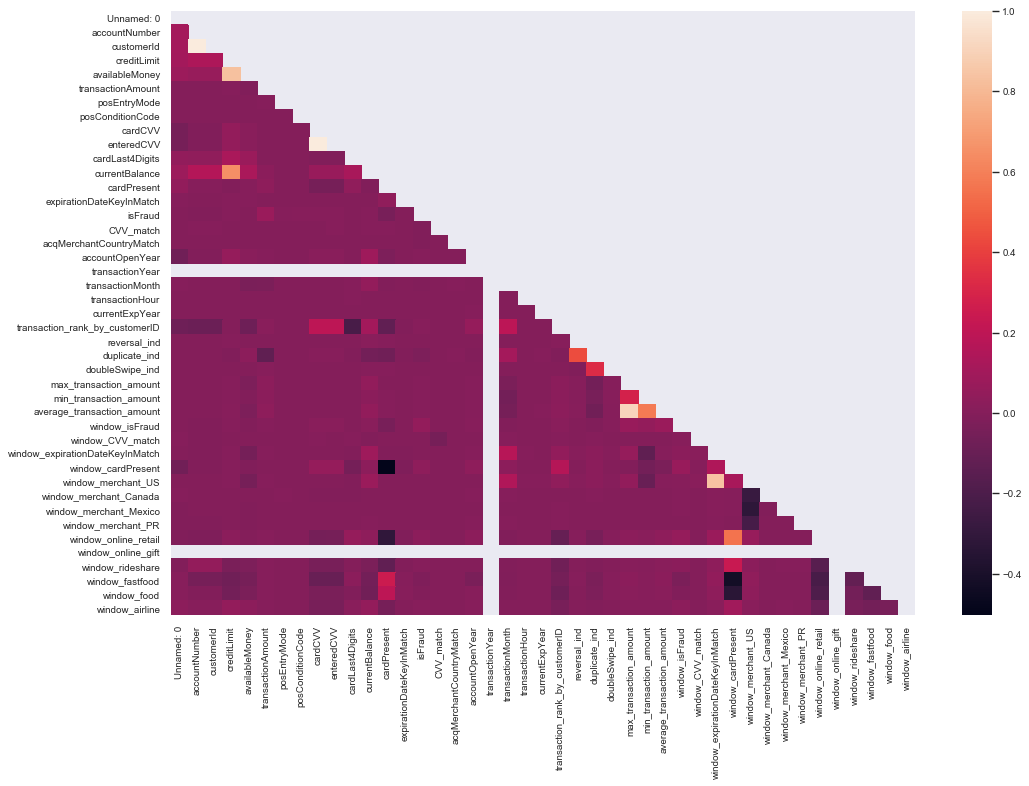

In [112]:
plt.figure(figsize=(15,10), dpi= 80)
sns.set(font_scale=0.8)
matrix = np.triu(new_df.corr())
sns.heatmap(new_df.corr(),
            #annot = True,
            
            mask = matrix)

## - Unbalanced Dataset

### - Train-Test Split (Stratified)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

In [182]:
print(sum(y_train==1)/len(y_train))
print(sum(y_test==1)/len(y_test))

0.015925036424478702
0.015476306541929304


The train and test datasets are not balanced (1.6% fraud transactions). Next, we try SMOTE over sampling to get to 50/50 proportion.

## Model 1: Random Forest with SMOTE Over-sampling

The classes of target variable are highly imbalanced, as there are 1.6% of fraudulant transactions. We use SMOTE over-sampling from imblearn package.

In [148]:
sm = SMOTE(random_state=37)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(1083376, 76)
(1083376,)


In [149]:
print(sum(y_train_smote==1)/len(y_train_smote))

0.5


Now the classes of both train and test datasets are balanced. Next, we train a RF model on the over-sampled train set.

### - Random Forest Classification Model

In [222]:
rfc_smote = RandomForestClassifier(n_estimators = 400)
rfc_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_estimators=400)

In [223]:
y_pred_smote = rfc_smote.predict(X_test)
f1_score(y_test, y_pred_smote, average='weighted')

0.9766045703538602

In [224]:
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_pred_smote).ravel()
(tn1, fp1, fn1, tp1)

(232040, 218, 3629, 22)

### - Random Forest with GridSearchCV

We can also use several performance metrics for GridSearchCV. 
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [ ]:
rfc = RandomForestClassifier()

parameters = { 
    #'max_depth': [4, 5, 6, 7, 8],
    'n_estimators': [200, 300, 400]
}

scoring = make_scorer(matthews_corrcoef)

clf = GridSearchCV(estimator=rfc,
                   param_grid = parameters,
                   cv = 5,
                   scoring = scoring)
clf.fit(X_train_smote,y_train_smote)

In [ ]:
clf.best_estimator_

In [ ]:
clf.best_score_

### - Feature Importance

In [225]:
features1 = []
importances1 = []
for feature, importance in zip(X.columns, rfc_smote.feature_importances_):
    features1.append(feature)
    importances1.append(importance)
feature_importance_df1 = pd.DataFrame({'Name': features1,
                                  'feature_importance': importances1})
feature_importance_df1.sort_values(by=['feature_importance'], ascending=False).head(20)

,Name,feature_importance
67,posEntryMode_5.0,0.155736
0,transactionAmount,0.089538
66,posEntryMode_2.0,0.064069
68,posEntryMode_9.0,0.049270
63,posConditionCode_8.0,0.047736
42,merchantCategoryCode_fastfood,0.040096
62,posConditionCode_1.0,0.034771
41,merchantCategoryCode_entertainment,0.031647
29,transactionMonth,0.024425
8,min_transaction_amount,0.024053


### - Feature Importance Plot

Text(0, 0.5, 'RF Feature Importance')

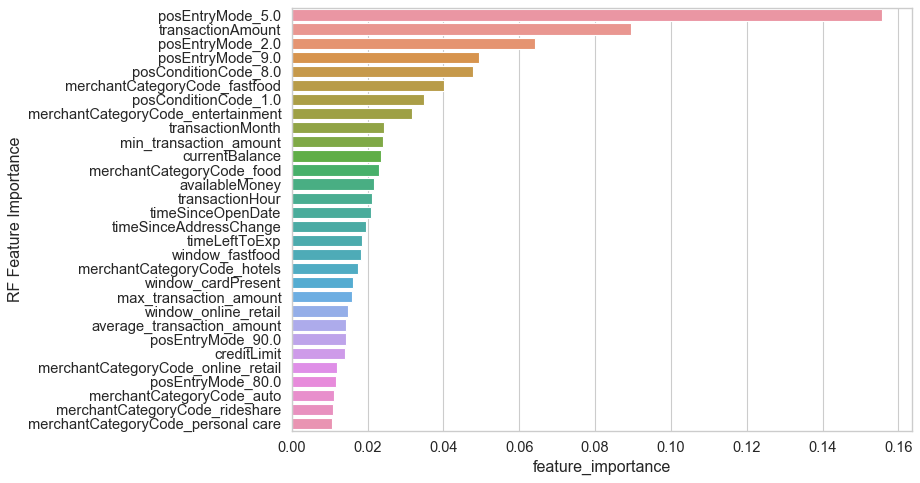

In [226]:
plt.figure(figsize=(10,7), dpi= 80)
sns.set(font_scale = 1.2,
       style = 'whitegrid')
fi_plot = sns.barplot(data = feature_importance_df1.sort_values(by=['feature_importance'], ascending=False)[0:30],
            y = 'Name', x = 'feature_importance')
plt.ylabel("RF Feature Importance")

### - Performance Metrics

In [227]:
#Performance Measures

#import packages
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

#Calculate metrics
y_pred_smote = rfc_smote.predict(X_test)
MCC = matthews_corrcoef(y_test, y_pred_smote)
print('MCC= ', MCC)
F1 = f1_score(y_test, y_pred_smote, average='weighted')
print('Balanced F1 Score= ', F1)
f2_score = fbeta_score(y_test, y_pred_smote_tomek, beta=2)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_smote, pos_label=1)
AUC = metrics.auc(fpr, tpr)
print('AUC-ROC= ', AUC)
RECALL = recall_score(y_test, y_pred_smote)#, average='weighted')
print('Recall= ', RECALL)
PRECISION = precision_score(y_test, y_pred_smote)#, average='weighted')
print('Precision= ', PRECISION)

MCC=  0.019697344012878096
Balanced F1 Score=  0.9766045703538602
AUC-ROC=  0.5025435674995105
Recall=  0.006025746370857299
Precision=  0.09166666666666666


### - Confusion Matrix

Text(10.999999999999998, 0.5, 'Actual')

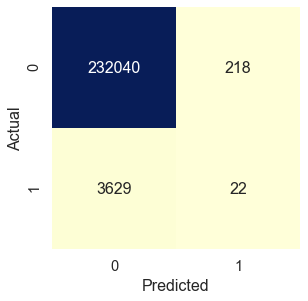

In [228]:
df_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(4,4), dpi= 80)
sns.set(font_scale = 1.2,
       style = 'whitegrid')
sns.heatmap(df_confusion_matrix, annot=True,
            cmap="YlGnBu", cbar = False,
           fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### - ROC Curve

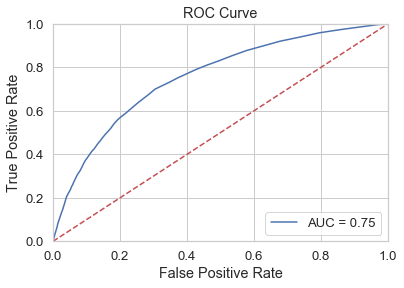

In [229]:
probs = rfc_smote.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
AUC = metrics.auc(fpr, tpr)
#*********************************
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model 2: Random Forest with Random Undersampling

In [168]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [169]:
print(X_train_rus.shape)
print(y_train_rus.shape)
print(sum(y_train_rus==1)/len(y_train_rus))

(17532, 76)
(17532,)
0.5


### - Random Forest with GridSearchCV

We can also use several performance metrics for GridSearchCV. 
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [199]:
rfc = RandomForestClassifier()

parameters = { 
    #'max_depth': [4, 5, 6, 7, 8],
    'n_estimators': [200, 300, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

scoring = make_scorer(matthews_corrcoef)

clf = GridSearchCV(estimator=rfc,
                   param_grid = parameters,
                   cv = 5,
                   scoring = scoring)
clf.fit(X_train_rus, y_train_rus)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 300, 400]},
             scoring=make_scorer(matthews_corrcoef))

In [200]:
clf.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=400)

In [201]:
clf.best_score_

0.44032704432158304

### - Feature Importance

In [176]:
features = []
importances = []
for feature, importance in zip(X.columns, clf.best_estimator_.feature_importances_):
    features.append(feature)
    importances.append(importance)
feature_importance_df = pd.DataFrame({'Name': features,
                                  'feature_importance': importances})
feature_importance_df.sort_values(by=['feature_importance'], ascending=False).head(20)

,Name,feature_importance
0,transactionAmount,0.108044
4,timeSinceOpenDate,0.062151
3,currentBalance,0.061520
1,availableMoney,0.060416
6,timeLeftToExp,0.060053
5,timeSinceAddressChange,0.059478
9,average_transaction_amount,0.058673
7,max_transaction_amount,0.058653
8,min_transaction_amount,0.057397
28,transactionHour,0.048773


### - Feature Importance Plot

Text(0, 0.5, 'RF Feature Importance')

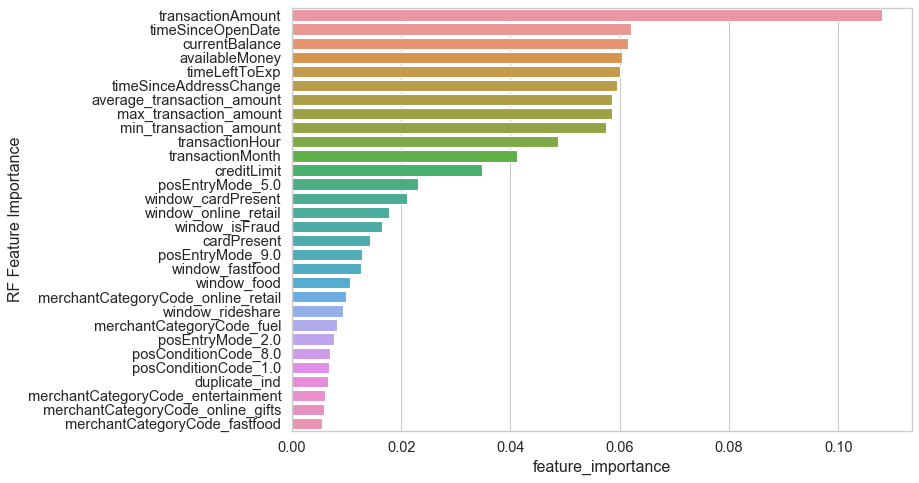

In [177]:
plt.figure(figsize=(10,7), dpi= 80)
sns.set(font_scale = 1.2,
       style = 'whitegrid')
fi_plot = sns.barplot(data = feature_importance_df.sort_values(by=['feature_importance'], ascending=False)[0:30],
            y = 'Name', x = 'feature_importance')
plt.ylabel("RF Feature Importance")

### - Performance Metrics

In [266]:
#Performance Measures

#import packages
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

#calculate values
y_pred_rus = clf.predict(X_test)
MCC = matthews_corrcoef(y_test, y_pred_rus)
print('MCC= ', MCC)
F1 = f1_score(y_test, y_pred_rus)#, average='weighted')
print('Balanced F1 Score= ', F1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rus, pos_label=1)
AUC = metrics.auc(fpr, tpr)
print('AUC-ROC= ', AUC)
RECALL = recall_score(y_test, y_pred_rus)#, average='weighted')
print('Recall= ', RECALL)
PRECISION = precision_score(y_test, y_pred_rus)#, average='weighted')
print('Precision= ', PRECISION)

MCC=  0.11810517907149783
Balanced F1 Score=  0.07364674817748694
AUC-ROC=  0.7147801872707982
Recall=  0.7028211448918105
Precision=  0.038859358199688034


### - Confusion Matrix

Text(10.999999999999998, 0.5, 'Actual')

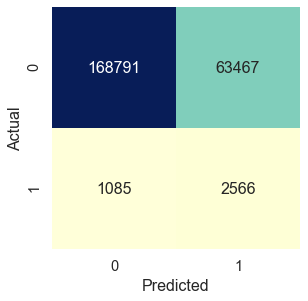

In [215]:
df_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rus)
plt.figure(figsize=(4,4), dpi= 80)
sns.set(font_scale = 1.2,
       style = 'whitegrid')
sns.heatmap(df_confusion_matrix, annot=True,
            cmap="YlGnBu", cbar = False,
           fmt = '.0f')
plt.xlabel("Predicted")
plt.ylabel("Actual")

### - ROC Curve

In [220]:
preds

array([0.4075, 0.2   , 0.6525, ..., 0.7425, 0.1875, 0.5425])

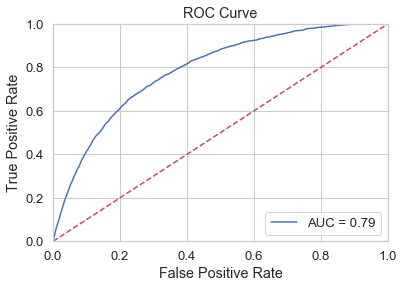

In [221]:
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
AUC = metrics.auc(fpr, tpr)
#*********************************
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## - Combined Over and Under Sampling

In [230]:
from imblearn.combine import SMOTETomek

In [232]:
sm = SMOTETomek(random_state=37)
X_train_smote_tomek, y_train_smote_tomek = sm.fit_resample(X_train, y_train)
print(X_train_smote_tomek.shape)
print(y_train_smote_tomek.shape)

(1082674, 76)
(1082674,)


In [233]:
print(sum(y_train_smote_tomek==1)/len(y_train_smote_tomek))

0.5


### - Random Forest Classification Model

In [234]:
rfc_smote_tomek = RandomForestClassifier(n_estimators = 200)
rfc_smote.fit(X_train_smote_tomek, y_train_smote_tomek)

RandomForestClassifier(n_estimators=400)

In [235]:
y_pred_smote_tomek = rfc_smote.predict(X_test)
f1_score(y_test, y_pred_smote_tomek, average='weighted')

0.976593739094754

In [236]:
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_pred_smote_tomek).ravel()
(tn1, fp1, fn1, tp1)

(232035, 223, 3629, 22)

In [237]:
from sklearn.metrics import fbeta_score
f2_score = fbeta_score(y_test, y_pred_smote_tomek, beta=2)
print('F2-Score= ', f2_score)

F2-Score=  0.007407906256313555


### - Feature Importance

In [ ]:
features1 = []
importances1 = []
for feature, importance in zip(X.columns, rfc_smote_tomek.feature_importances_):
    features1.append(feature)
    importances1.append(importance)
feature_importance_df1 = pd.DataFrame({'Name': features1,
                                  'feature_importance': importances1})
feature_importance_df1.sort_values(by=['feature_importance'], ascending=False).head(20)

### - Feature Importance Plot

In [ ]:
plt.figure(figsize=(10,7), dpi= 80)
sns.set(font_scale = 1.2,
       style = 'whitegrid')
fi_plot = sns.barplot(data = feature_importance_df1.sort_values(by=['feature_importance'], ascending=False)[0:30],
            y = 'Name', x = 'feature_importance')
plt.ylabel("RF Feature Importance")

### - Performance Metrics

In [ ]:
#Performance Measures

#import packages
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#Calculate metrics
y_pred_smote = rfc_smote.predict(X_test)
MCC = matthews_corrcoef(y_test, y_pred_smote)
print('MCC= ', MCC)
F1 = f1_score(y_test, y_pred_smote, average='weighted')
print('Balanced F1 Score= ', F1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_smote, pos_label=1)
AUC = metrics.auc(fpr, tpr)
print('AUC-ROC= ', AUC)
RECALL = recall_score(y_test, y_pred_smote)#, average='weighted')
print('Recall= ', RECALL)
PRECISION = precision_score(y_test, y_pred_smote)#, average='weighted')
print('Precision= ', PRECISION)

### - Confusion Matrix

In [ ]:
df_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(4,4), dpi= 80)
sns.set(font_scale = 1.2,
       style = 'whitegrid')
sns.heatmap(df_confusion_matrix, annot=True,
            cmap="YlGnBu", cbar = False,
           fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### - ROC Curve

In [ ]:
probs = rfc_smote.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
AUC = metrics.auc(fpr, tpr)
#*********************************
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## - Oversampling with Cross-validation

In [ ]:
model = pipeline(['sampling', RandomUnderSampler(),
                 'classification', RandomForestClassifier()])
params = {'criterion': ['gini', 'entropy'],
          'n_estimators': [100,200,300]}
grid = GridSearchCV(model, cv=5)
grid.fit(X_train, y_train)